In [1]:
import os, sys, random

repo_dir = "gpt-2-based-llm"
repo_url = f"https://github.com/mathensley/{repo_dir}.git"

!rm -rf {repo_dir}
!git clone {repo_url} {repo_dir}
project_path = os.path.join(os.getcwd(), repo_dir, 'src')

if project_path not in sys.path:
    sys.path.append(project_path)

print(f"Repositório público clonado e caminho adicionado ao sys.path: {project_path}")

SEED = 40
MAX_MB = 200
MIN_PARAGRAPH_LENGTH = 0
random.seed(SEED)

Cloning into 'gpt-2-based-llm'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 50 (delta 14), reused 45 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (50/50), 20.22 KiB | 5.05 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Repositório público clonado e caminho adicionado ao sys.path: /kaggle/working/gpt-2-based-llm/src


In [2]:
!pip install --upgrade pip
!pip install -r /kaggle/working/gpt-2-based-llm/requirements.txt
!apt-get update -qq
!apt install chromium-chromedriver -y
!pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Looking in indexes: https://download.pytorch.org/whl/cu126
ERROR: Could not find a version that satisfies the requirement dotenv (from versions: none)
ERROR: No matching distribution found for dotenv
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  apparmor chromium-browser libfuse3-3 libpam-systemd libsystemd0 libudev1
  snapd squashfs-tools systemd systemd-hwe-hwdb systemd-sysv udev
Suggested packages:
  apparmor-profiles-extra apparmor-utils fuse3 zenity | kdialog
  syst

In [ ]:
!python /kaggle/working/{repo_dir}/scripts/download_data.py {MAX_MB} {SEED}
!python /kaggle/working/{repo_dir}/scripts/prepare_data.py {MIN_PARAGRAPH_LENGTH}

In [5]:
import torch, tiktoken
from torch.optim.lr_scheduler import CosineAnnealingLR
import time
import csv
import os
import sys
import wandb
from itertools import cycle
from pathlib import Path

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [6]:
from utils import get_loaders
from model.gpt2_original import GPT2ModelOriginal

In [7]:
torch.manual_seed(40)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Usando dispositivo: {device.type}")

TOKENIZER = tiktoken.get_encoding("gpt2")
print(TOKENIZER.n_vocab)

Usando dispositivo: cuda
50257


In [48]:
CONFIG = {
    "vocab_size": TOKENIZER.n_vocab,
    "embedding_dim": 512,
    "context_length": 256,
    "num_layers": 8,
    "num_heads": 8,
    "bias": False,
    
    "batch_size": 8,
    "max_epochs": 2,
    "num_workers": 0,
    "stride": 256 // 2,
    "dtype": torch.float32,
    "device": device,

    "eval_freq": 100,
    "eval_iter": 16,

    "save_wdb": True,
    "save_freq_wdb": 5000,
    "user": "matheus-figueiredo-silva-ufcg",
    "project": "gpt2-original",
    "name": "test1",
    "run_id": "gpt2-original-run1",
    "version": "v2",
    "file_name": "mini_mlp.pth"
}

In [9]:
os.environ["WANDB_API_KEY"] = "8dc112bdcb6f80c3fb20da526d4a52923f2074f2"

In [10]:
train_loader, test_loader, val_loader = get_loaders(
    data_path="/kaggle/input/processed1",
    tokenizer=TOKENIZER,
    max_length=CONFIG["context_length"],
    batch_sz=CONFIG["batch_size"],
    num_workers=CONFIG["num_workers"],
    stride=CONFIG["stride"]
)

print(f"Tamanho do conjunto de treinamento: {len(train_loader)}\nTamanho do conjunto de teste: {len(test_loader)}\nTamanho do conjunto de validação: {len(val_loader)}")

Arquivos carregados!

Dataset de TRAIN está pronto!
Dataloader de TRAIN está pronto!
Dataset de TEST está pronto!
Dataloader de TEST está pronto!
Dataset de VALIDATION está pronto!
Dataloader de VALIDATION está pronto!


- Train
	Total de amostras: 101482
	Tokens em cada amostra: 256
	Número de batches: 12685
	Número de amostras por batch: 8
- Test
	Total de amostras: 13471
	Tokens em cada amostra: 256
	Número de batches: 1683
	Número de amostras por batch: 8
- Validation
	Total de amostras: 12843
	Tokens em cada amostra: 256
	Número de batches: 1605
	Número de amostras por batch: 8


Tamanho do conjunto de treinamento: 12685
Tamanho do conjunto de teste: 1683
Tamanho do conjunto de validação: 1605


## Funções de Treino

In [20]:
from train.eval import calc_loss_batch_by_cross_entropy, evaluate_model
from utils.plots import plot_graph
from utils.generate import generate_text, generate_and_print_sample

In [21]:
from utils import text_to_token_ids, token_ids_to_text

In [22]:
def fetch_weights_and_bias(user, project, name, version, file_name):
    """
    Busca um artifact de pesos salvo no W&B.
    Exemplo de version: 'v1', 'v2', etc (não o run id).
    """
    try:
        api = wandb.Api()
        artifact = api.artifact(f"{user}/{project}/{name}:{version}", type="model")
        artifact_dir = artifact.download()
        file_path = os.path.join(artifact_dir, file_name)
        print(f"Fetch success -> {file_path}")
        return True

    except Exception as e:
        print(f"Fetch Error: {e}")
        return False


def load_weights_and_bias(file_name):
    try:
        checkpoint = torch.load(file_name, map_location="cpu")
        return True, checkpoint
    except Exception as e:
        print(f"Load error: {e}")
        return False, {}

In [23]:
def generate_and_print_sample_for_qwen3(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.cfg["context_length"]

    encoded = text_to_token_ids(start_context, tokenizer, device).to(device)

    with torch.no_grad():
        token_ids = generate_text(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )

    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(f"Amostra Gerada: '{decoded_text.replace(os.linesep, ' ')}'")
    model.train()

In [24]:
def train_aux(
        wandb_run, model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, 
        start_context, tokenizer, save_freq_wdb, file_name, save_wdb, state_dict, name, start_time
):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    epochs_complete = state_dict.get("epoch", 0)
    batchs_complete = state_dict.get("batch", 0)
    accumulated_time = state_dict.get("train_time", 0)

    for epoch in range(epochs_complete, num_epochs):
        model.train()

        for batch_idx, (input_batch, target_batch) in enumerate(train_loader):
            if epoch == epochs_complete and batch_idx < batchs_complete:
                continue

            optimizer.zero_grad()
            loss = calc_loss_batch_by_cross_entropy(
                model,
                input_batch,
                target_batch,
                device
            )
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model,
                    train_loader,
                    val_loader,
                    device,
                    eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                wandb_run.log({
                    "train_loss": train_loss,
                    "val_loss": val_loss,
                    "tokens_seen": tokens_seen,
                    "epoch": epoch + 1,
                    "global_step": global_step,
                })

                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}"
                )

            # salva peso só após o primeiro batch
            if save_wdb and global_step > 0 and global_step % save_freq_wdb == 0:
                elapsed_time = time.time() - start_time + accumulated_time
                torch.save({
                    "epoch": epoch,
                    "model_state": model.state_dict(),
                    "optimizer_state": optimizer.state_dict(),
                    "batch": batch_idx,
                    "train_time": elapsed_time
                },  file_name)
                artifact = wandb.Artifact(name, type="model")
                artifact.add_file(file_name)
                wandb_run.log_artifact(artifact)
        print("\nEXEMPLO DE GERAÇÃO:")
        #generate_and_print_sample(model, tokenizer, device, start_context)
        generate_and_print_sample_for_qwen3(model, tokenizer, device, start_context)

        # salva após finalizar o treino
        elapsed_time = time.time() - start_time + accumulated_time
        if save_wdb:
          torch.save({
              "epoch": epoch,
              "model_state": model.state_dict(),
              "optimizer_state": optimizer.state_dict(),
              "batch": batch_idx,
              "train_time": elapsed_time
          },  file_name)
          artifact = wandb.Artifact(file_name.split(".")[0] + "_final", type="model")
          artifact.add_file(file_name)
          wandb_run.log_artifact(artifact)

    return train_losses, val_losses, track_tokens_seen, elapsed_time


def run_train(model, optimizer, config, tokenizer, start_context="Bom dia!"):
    run = wandb.init(project=config["project"], name=config["name"], id=config["run_id"], resume="allow")
    res_fetch = fetch_weights_and_bias(
        user=config["user"],
        project=config["project"],
        name=config["name"],
        version=config["version"],
        file_name=config["file_name"]
    )

    state_dict = {}
    if res_fetch:
        loaded, checkpoint = load_weights_and_bias(
            file_name=f"/kaggle/working/artifacts/{config['name']}:{config['version']}/{config['file_name']}"
        )
        if loaded:
            model.load_state_dict(checkpoint["model_state"])
            optimizer.load_state_dict(checkpoint["optimizer_state"])
            state_dict["epoch"] = checkpoint.get("epoch", 0)
            state_dict["batch"] = checkpoint.get("batch", 0)
            state_dict["train_time"] = checkpoint.get("train_time", 0.0)
            print("Pesos carregados com sucesso!")

    print("\nEPOCHS/BATCHS RECUPERADOS: ", state_dict)
    num_epochs = config["max_epochs"]

    start_time = time.time()
    train_losses, val_losses, tokens_seen, total_train_time = train_aux(
        run, model, train_loader, val_loader, optimizer, device,
        num_epochs=num_epochs, eval_freq=100, eval_iter=16,
        start_context=start_context, tokenizer=tokenizer,
        save_freq_wdb=config["save_freq_wdb"], file_name=config["file_name"],
        save_wdb=config["save_wdb"], state_dict=state_dict, 
        name=config["name"], start_time=start_time
    )
    print("\nGRÁFICO DE PERDA DURANTE O TREINO:")
    epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
    plot_graph(epochs_tensor, tokens_seen, train_losses, val_losses)
    return tokens_seen[-1], total_train_time

## Treino

Número de parâmetros (sem head): 51,045,888


wandb: Currently logged in as: matheus-figueiredo-silva (matheus-figueiredo-silva-ufcg) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Fetch Error: artifact membership 'test1:v2' not found in 'matheus-figueiredo-silva-ufcg/gpt2-original'

EPOCHS/BATCHS RECUPERADOS:  {}
Ep 1 (Step 000000): Train loss 10.432, Val loss 10.564
Ep 1 (Step 000100): Train loss 5.446, Val loss 5.396
Ep 1 (Step 000200): Train loss 5.100, Val loss 4.911
Ep 1 (Step 000300): Train loss 4.848, Val loss 4.672
Ep 1 (Step 000400): Train loss 4.588, Val loss 4.561
Ep 1 (Step 000500): Train loss 4.465, Val loss 4.504
Ep 1 (Step 000600): Train loss 4.326, Val loss 4.428
Ep 1 (Step 000700): Train loss 4.377, Val loss 4.380
Ep 1 (Step 000800): Train loss 4.328, Val loss 4.377
Ep 1 (Step 000900): Train loss 4.231, Val loss 4.287
Ep 1 (Step 001000): Train loss 4.097, Val loss 4.177
Ep 1 (Step 001100): Train loss 4.199, Val loss 4.175
Ep 1 (Step 001200): Train loss 4.067, Val loss 4.075
Ep 1 (Step 001300): Train loss 4.073, Val loss 4.029
Ep 1 (Step 001400): Train loss 3.965, Val loss 4.098
Ep 1 (Step 001500): Train loss 3.960, Val loss 3.962
Ep 1 (Step 0016

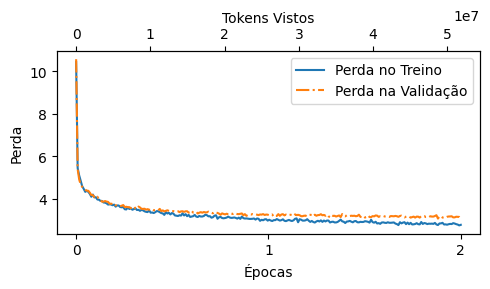


DESEMPENHO:
Tempo total: 3882.26 s
Tokens/s: 13346.97
Memória máxima: 3243.45 MB

Tempo total de treino: 3858.61 s (64.31 min)


In [13]:
model = GPT2ModelOriginal(CONFIG, device).to(device=device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

params = sum(p.numel() for p in model.parameters())
params_model = params - sum(p.numel() for p in model.out_head.parameters())
print(f"Número de parâmetros (sem head): {params_model:,}")

if device.type == "cuda": torch.cuda.reset_peak_memory_stats(device)

start_time = time.time()
tokens_processed, total_train_time = run_train(model=model, optimizer=optimizer, config=CONFIG, tokenizer=TOKENIZER)
end_time = time.time()

elapsed = end_time - start_time
tokens_per_sec = tokens_processed / elapsed
max_memory = torch.cuda.max_memory_allocated(device) / (1024**2)  # MB

print("\nDESEMPENHO:")
print(f"Tempo total: {elapsed:.2f} s")
print(f"Tokens/s: {tokens_per_sec:.2f}")
print(f"Memória máxima: {max_memory:.2f} MB")

print(f"\nTempo total de treino: {total_train_time:.2f} s ({total_train_time/60:.2f} min)")

# Carregar modelo

In [ ]:
def load_latest_model(config, model_class, device):
    api = wandb.Api()
    artifact = api.artifact(
        f"{config['user']}/{config['project']}/{config['name']}:latest", type="model"
    )
    artifact_dir = artifact.download()

    checkpoint_path = os.path.join(artifact_dir, config["file_name"])
    print(f"Carregando pesos do checkpoint: {checkpoint_path}")

    # Carregar o checkpoint completo
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Inicializa modelo com a mesma config
    model = model_class(config, device).to(device)

    model.load_state_dict(checkpoint["model_state"])
    print("Pesos carregaos com sucesso!")

    return model

In [ ]:
config = {
    "vocab_size": TOKENIZER.n_vocab,
    "embedding_dim": 512,
    "context_length": 384,
    "num_layers": 8,
    "num_heads": 8,
    "bias": False,
    "max_epochs": 2,
    "dtype": torch.float32,
    "user": "matheus-figueiredo-silva-ufcg",
    "project": "gpt2-original",
    "name": "mini_mlp_final",
    "run_id": "gpt2-original-run1",
    "version": "v0",
    "file_name": "mini_mlp.pth"
}

model_loaded = load_latest_model(config, GPT2ModelOriginal, device)

In [21]:
generate_and_print_sample(model, TOKENIZER, device, start_context="lisboa")

Amostra Gerada: 'lisboa, e ao outro dia, que era o mais importante dos seus amigos, e que o mais velho de todos os seus amigos, e que o mais velho de todos'


In [30]:
def generate_text_temp(model, prompt_text, tokenizer, device, max_new_tokens=50, temperature=0.8, top_k=50):
    model.eval()

    idx = text_to_token_ids(prompt_text, tokenizer, device)

    #context_size = model.pos_embeddings.weight.shape[0]
    context_size = model.cfg["context_length"]

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        logits = model(idx_cond)
        logits = logits[:, -1, :] / temperature
        if top_k is not None:
            v, ix = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('inf')

        probs = torch.nn.functional.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_id), dim=1)

    decoded = token_ids_to_text(idx, tokenizer)
    #print(f"Amostra Gerada: '{decoded.replace(os.linesep, ' ')}'")

    model.train()
    return decoded

In [32]:
generate_text_temp(model, "bom dia", tokenizer=TOKENIZER, device=device, max_new_tokens=60)

'bom dia de noite ao seu hospede. Apenas achou a esperana, porque as pessoas que iam, como estavam muito bruscas e muito linda saborosas, podiam fazer-se'

# Perplexidade

In [18]:
def compute_perplexity(model, data_loader, device):
    model.eval()
    total_loss = 0
    n_batches = 0

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(data_loader):
            x, y = x.to(device), y.to(device)
            loss = calc_loss_batch_by_cross_entropy(model, x, y, device)

            print(f"Batch {batch_idx+1}/{len(data_loader)}, Loss: {loss.item():.4f}")

            total_loss += loss.item()
            n_batches += 1

            if (batch_idx + 1) % 10 == 0:
                avg_loss_partial = total_loss / n_batches
                print(f"  Média parcial até aqui: {avg_loss_partial:.4f}")

    avg_loss = total_loss / n_batches
    print(f"Loss média final no dataset de teste: {avg_loss:.4f}")

    perplexity = torch.exp(torch.tensor(avg_loss))
    print(f"Perplexidade calculada: {perplexity.item():.2f}")

    return perplexity.item()

perplexity_test = compute_perplexity(model, test_loader, device)

Batch 1/1683, Loss: 2.9609
Batch 2/1683, Loss: 2.7716
Batch 3/1683, Loss: 3.1394
Batch 4/1683, Loss: 3.1359
Batch 5/1683, Loss: 3.2410
Batch 6/1683, Loss: 3.6303
Batch 7/1683, Loss: 3.3782
Batch 8/1683, Loss: 2.8299
Batch 9/1683, Loss: 2.9114
Batch 10/1683, Loss: 2.9334
  Média parcial até aqui: 3.0932
Batch 11/1683, Loss: 3.1096
Batch 12/1683, Loss: 3.0884
Batch 13/1683, Loss: 3.0380
Batch 14/1683, Loss: 3.3291
Batch 15/1683, Loss: 3.4281
Batch 16/1683, Loss: 3.0453
Batch 17/1683, Loss: 3.5430
Batch 18/1683, Loss: 3.1123
Batch 19/1683, Loss: 3.2825
Batch 20/1683, Loss: 3.9358
  Média parcial até aqui: 3.1922
Batch 21/1683, Loss: 3.6103
Batch 22/1683, Loss: 3.2874
Batch 23/1683, Loss: 3.4338
Batch 24/1683, Loss: 3.1249
Batch 25/1683, Loss: 3.8929
Batch 26/1683, Loss: 2.9227
Batch 27/1683, Loss: 3.0308
Batch 28/1683, Loss: 3.2628
Batch 29/1683, Loss: 3.1549
Batch 30/1683, Loss: 3.0843
  Média parcial até aqui: 3.2216
Batch 31/1683, Loss: 3.1147
Batch 32/1683, Loss: 3.6929
Batch 33/1683,

# Qwen3

In [26]:
from model.gpt2_to_qwen3 import GTP2ModelToQwen3

In [8]:
CONFIG = {
    "vocab_size": TOKENIZER.n_vocab,
    "emb_dim": 512,
    "context_length": 256,
    "n_layers": 8,
    "n_heads": 8,
    "head_dim": 64,
    "hidden_dim": 2048,
    "n_kv_groups": 4,
    "qk_norm": True,
    "rope_base": 10000.0,
    "num_experts": 4,                  # MoE: quantidade de experts
    "num_experts_per_token": 2,        # experts ativos por token
    "moe_intermediate_size": 1024,
    "bias": False,
    
    "batch_size": 8,
    "max_epochs": 2,
    "num_workers": 0,
    "stride": 256 // 2,
    "dtype": torch.bfloat16,
    "device": device,

    "eval_freq": 100,
    "eval_iter": 16,

    "save_wdb": True,
    "save_freq_wdb": 5000,
    "user": "matheus-figueiredo-silva-ufcg",
    "project": "gpt2-to-qwen3",
    "name": "test1",
    "run_id": "gpt2-to-qwen3-run1",
    "version": "v1",
    "file_name": "mini_mlp.pth"
}

Número de parâmetros (sem head): 82,380,800


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
tokens_seen,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
train_loss,▇▇███▅▅▇▇▆▆▅▇▇▇▆▄▁█▅▅▃▅▄▄▃▅
val_loss,▇▆▅▇▅▅█▂▄▅▃▆▅▃▁▃▂▂▄▅▅▄▄▃▁▁▃
epoch,1
global_step,2600
tokens_seen,5326848
train_loss,2.89453
val_loss,3.12012


wandb: Downloading large artifact test1:v1, 618.83MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.6 (394.1MB/s)


Fetch success -> /kaggle/working/artifacts/test1:v1/mini_mlp.pth
Pesos carregados com sucesso!

EPOCHS/BATCHS RECUPERADOS:  {'epoch': 0, 'batch': 10000, 'train_time': 2311.222449541092}
Ep 1 (Step 000000): Train loss 2.983, Val loss 3.173
Ep 1 (Step 000100): Train loss 2.987, Val loss 3.177
Ep 1 (Step 000200): Train loss 2.917, Val loss 3.195
Ep 1 (Step 000300): Train loss 2.963, Val loss 3.185
Ep 1 (Step 000400): Train loss 2.982, Val loss 3.146
Ep 1 (Step 000500): Train loss 2.902, Val loss 3.140
Ep 1 (Step 000600): Train loss 2.894, Val loss 3.119
Ep 1 (Step 000700): Train loss 2.956, Val loss 3.168
Ep 1 (Step 000800): Train loss 2.963, Val loss 3.148
Ep 1 (Step 000900): Train loss 2.950, Val loss 3.162
Ep 1 (Step 001000): Train loss 2.909, Val loss 3.144
Ep 1 (Step 001100): Train loss 2.894, Val loss 3.183
Ep 1 (Step 001200): Train loss 2.939, Val loss 3.109
Ep 1 (Step 001300): Train loss 2.983, Val loss 3.173
Ep 1 (Step 001400): Train loss 2.890, Val loss 3.108
Ep 1 (Step 001500):

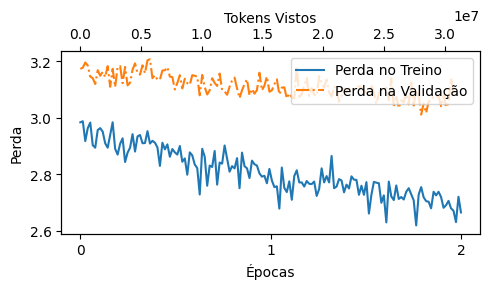


DESEMPENHO:
Tempo total: 3623.42 s
Tokens/s: 8648.30
Memória máxima: 2823.18 MB

Tempo total de treino: 5918.50 s (98.64 min)


In [27]:
model_qwen3 = GTP2ModelToQwen3(CONFIG).to(device=device, dtype=CONFIG["dtype"])

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

optimizer = torch.optim.AdamW(model_qwen3.parameters(), lr=0.0004, weight_decay=0.1)

params = sum(p.numel() for p in model_qwen3.parameters())
params_model = params - sum(p.numel() for p in model_qwen3.out_head.parameters())
print(f"Número de parâmetros (sem head): {params_model:,}")

if device.type == "cuda": torch.cuda.reset_peak_memory_stats(device)

start_time = time.time()
tokens_processed, total_train_time = run_train(model=model_qwen3, optimizer=optimizer, config=CONFIG, tokenizer=TOKENIZER)
end_time = time.time()

elapsed = end_time - start_time
tokens_per_sec = tokens_processed / elapsed
max_memory = torch.cuda.max_memory_allocated(device) / (1024**2)  # MB

print("\nDESEMPENHO:")
print(f"Tempo total: {elapsed:.2f} s")
print(f"Tokens/s: {tokens_per_sec:.2f}")
print(f"Memória máxima: {max_memory:.2f} MB")

print(f"\nTempo total de treino: {total_train_time:.2f} s ({total_train_time/60:.2f} min)")

In [28]:
def compute_perplexity(model, data_loader, device):
    model.eval()
    total_loss = 0
    n_batches = 0

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(data_loader):
            x, y = x.to(device), y.to(device)
            loss = calc_loss_batch_by_cross_entropy(model, x, y, device)

            print(f"Batch {batch_idx+1}/{len(data_loader)}, Loss: {loss.item():.4f}")

            total_loss += loss.item()
            n_batches += 1

            if (batch_idx + 1) % 10 == 0:
                avg_loss_partial = total_loss / n_batches
                print(f"  Média parcial até aqui: {avg_loss_partial:.4f}")

    avg_loss = total_loss / n_batches
    print(f"Loss média final no dataset de teste: {avg_loss:.4f}")

    perplexity = torch.exp(torch.tensor(avg_loss))
    print(f"Perplexidade calculada: {perplexity.item():.2f}")

    return perplexity.item()

perplexity_test = compute_perplexity(model_qwen3, test_loader, device)

Batch 1/1683, Loss: 3.4375
Batch 2/1683, Loss: 3.0781
Batch 3/1683, Loss: 3.0156
Batch 4/1683, Loss: 3.1094
Batch 5/1683, Loss: 3.0469
Batch 6/1683, Loss: 3.1875
Batch 7/1683, Loss: 3.4375
Batch 8/1683, Loss: 2.9531
Batch 9/1683, Loss: 3.1094
Batch 10/1683, Loss: 3.0938
  Média parcial até aqui: 3.1469
Batch 11/1683, Loss: 3.6094
Batch 12/1683, Loss: 3.2188
Batch 13/1683, Loss: 2.9688
Batch 14/1683, Loss: 2.7812
Batch 15/1683, Loss: 2.9844
Batch 16/1683, Loss: 3.2188
Batch 17/1683, Loss: 2.8906
Batch 18/1683, Loss: 2.6719
Batch 19/1683, Loss: 3.1719
Batch 20/1683, Loss: 3.0625
  Média parcial até aqui: 3.1023
Batch 21/1683, Loss: 3.1250
Batch 22/1683, Loss: 2.9844
Batch 23/1683, Loss: 3.0469
Batch 24/1683, Loss: 3.2031
Batch 25/1683, Loss: 3.2344
Batch 26/1683, Loss: 3.0781
Batch 27/1683, Loss: 3.2344
Batch 28/1683, Loss: 2.9844
Batch 29/1683, Loss: 3.2969
Batch 30/1683, Loss: 3.1875
  Média parcial até aqui: 3.1141
Batch 31/1683, Loss: 3.0000
Batch 32/1683, Loss: 3.6406
Batch 33/1683,

In [32]:
generate_text_temp(model_qwen3, "lisboa", tokenizer=TOKENIZER, device=device, max_new_tokens=60)

'lisboa, se faziam já nos prazos, e nada havia que a ajudasse, e tornasse o fim ás tres horas da manhã.\n\nPouco depois, chegou o tempo e viuva, e'